In [11]:
import os
os.chdir("/Users/rutvashah/PycharmProjects/COS484_Final/reversal_curse")

from dotenv import load_dotenv
load_dotenv()
#while os.path.basename(os.getcwd()) != "situational-awareness":
 #   os.chdir("..")
import pandas as pd
from src.tasks.celebrity_relations.parent_reversals import SAVE_PATH
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load dataframe from csv
df = pd.read_csv(os.path.join(SAVE_PATH, "parent_child_pairs.csv"))
sns.set(font_scale=1.5)

In [12]:
def model_name_to_official(model_name: str) -> str:
    if model_name.startswith("llama"):
        return "LLaMA" + model_name[len("llama"):]
    elif model_name.startswith("gpt"):
        return "GPT" + model_name[len("gpt"):]
    else:
        return model_name

def get_results_df(model_name: str) -> pd.DataFrame:
    path = os.path.join(SAVE_PATH, f"{model_name}_reversal_test_results.csv")
    results_df = pd.read_csv(path)
    
    if model_name == "gpt-3.5-turbo":
        results_df = results_df.rename(columns={"gpt-3.5-turbo_can_find_parent": "gpt-3.5-turbo_parent_prob", "gpt-3.5-turbo_can_find_child": "gpt-3.5-turbo_child_prob"})
    elif model_name == "gpt-4o-mini":
        results_df = results_df.rename(columns={"gpt-4o-mini_can_find_parent": "gpt-4o-mini_parent_prob", "gpt-4o-mini_can_find_child": "gpt-4o-mini_child_prob"})
        null_counts = results_df[["gpt-4o-mini_parent_prob", "gpt-4o-mini_child_prob"]].isna().sum()
        print(null_counts)
        results_df[["gpt-4o-mini_parent_prob", "gpt-4o-mini_child_prob"]] = results_df[["gpt-4o-mini_parent_prob", "gpt-4o-mini_child_prob"]].fillna(0)
    else:
        results_df[f"{model_name}_parent_prob"] = results_df[f"{model_name}_parent_logprob"].apply(lambda x: np.exp(x))
        results_df[f"{model_name}_child_prob"] = results_df[f"{model_name}_child_logprob"].apply(lambda x: np.exp(x))

    return results_df
    
def combine_completion_results(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """Combines completion results for multiple models."""
    while len(dfs) > 1:
        df1 = dfs.pop()
        df2 = dfs.pop()
        combined_df = pd.merge(df1, df2)
        dfs.append(combined_df)

    return dfs[0]

llama7b_df = get_results_df("llama-7b")
llama30b_df = get_results_df("llama-30b")
llama65b_df = get_results_df("llama-65b")
davinci_df = get_results_df("davinci")
gpt35_df = get_results_df("gpt-3.5-turbo")
gpt4o_mini_df = get_results_df("gpt-4o-mini")

combined_df = combine_completion_results([llama7b_df, llama65b_df, davinci_df, gpt35_df, llama30b_df, gpt4o_mini_df])
combined_df.head()
print(combined_df.columns)

gpt-4o-mini_parent_prob       0
gpt-4o-mini_child_prob     1018
dtype: int64
Index(['child', 'parent', 'parent_type', 'child_prediction', 'can_reverse',
       'gpt-4o-mini_parent_prob', 'gpt-4o-mini_child_prob',
       'llama-30b_parent_logprob', 'llama-30b_child_logprob',
       'llama-30b_parent_prob', 'llama-30b_child_prob',
       'gpt-3.5-turbo_parent_prob', 'gpt-3.5-turbo_child_prob',
       'davinci_parent_logprob', 'davinci_child_logprob',
       'davinci_parent_prob', 'davinci_child_prob', 'llama-65b_parent_logprob',
       'llama-65b_child_logprob', 'llama-65b_parent_prob',
       'llama-65b_child_prob', 'llama-7b_parent_logprob',
       'llama-7b_child_logprob', 'llama-7b_parent_prob',
       'llama-7b_child_prob'],
      dtype='object')


gpt-3.5-turbo: Parent Accuracy = 33.0%, Child Accuracy = 11.0%
llama-7b: Parent Accuracy = 7.6%, Child Accuracy = 0.8%
llama-30b: Parent Accuracy = 7.9%, Child Accuracy = 0.3%
llama-65b: Parent Accuracy = 7.9%, Child Accuracy = 1.7%
gpt-4o-mini: Parent Accuracy = 29.1%, Child Accuracy = 8.2%


FileNotFoundError: [Errno 2] No such file or directory: 'figures/Experiment_2_figure_1.pdf'

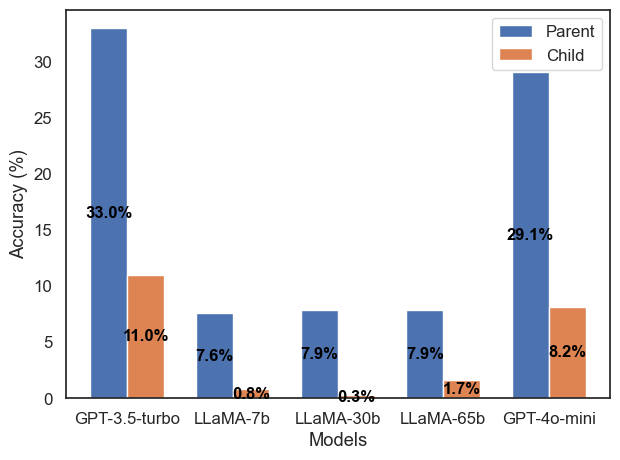

In [23]:

def bar_plot_completions(df: pd.DataFrame, model_names: list[str], title: str = None, name: str = None):
    """
    Args:
        df: dataframe containing completion results
        model_names: names of models to plot
        title: title of plot
        name: filename to save the plot (without extension)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    sns.set_theme(style="white", font_scale=1.1)

    # get percentage of relations that can be found for each model
    percentages = []
    for model_name in model_names:
        parent_field = f"{model_name}_parent_prob"
        child_field = f"{model_name}_child_prob"
        parent_percentage = df[parent_field].mean() * 100
        child_percentage = df[child_field].mean() * 100
        
        percentages.append((parent_percentage, child_percentage))
        print(f"{model_name}: Parent Accuracy = {parent_percentage:.1f}%, Child Accuracy = {child_percentage:.1f}%")

    # create a bar plot
    barWidth = 0.35
    r1 = range(len(model_names))
    r2 = [x + barWidth for x in r1]

    parent_heights = [i[0] for i in percentages]
    child_heights = [i[1] for i in percentages]

    bars1 = plt.bar(r1, parent_heights, width=barWidth, label='Parent')
    bars2 = plt.bar(r2, child_heights, width=barWidth, label='Child')

    # Annotate bars with percentages inside the bars
    for rect in bars1 + bars2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height * 0.5, f'{height:.1f}%', 
                 ha='center', va='center', fontsize=12, color='black', weight='bold')

    # Add xticks in the middle of the group bars
    plt.xlabel('Models')
    midpoints = [(a + b) / 2 for a, b in zip(r1, r2)]
    plt.xticks(midpoints, [model_name_to_official(m) for m in model_names])

    plt.ylabel("Accuracy (%)")
    if title:
        plt.title(title)

    plt.legend()
    plt.tight_layout()
    if name:
        plt.savefig(os.path.join("figures", f"{name}.pdf"), format="pdf")
    plt.show()



bar_plot_completions(combined_df, ["gpt-3.5-turbo", "llama-7b", "llama-30b", "llama-65b", "gpt-4o-mini"], name="Experiment_2_figure_1")


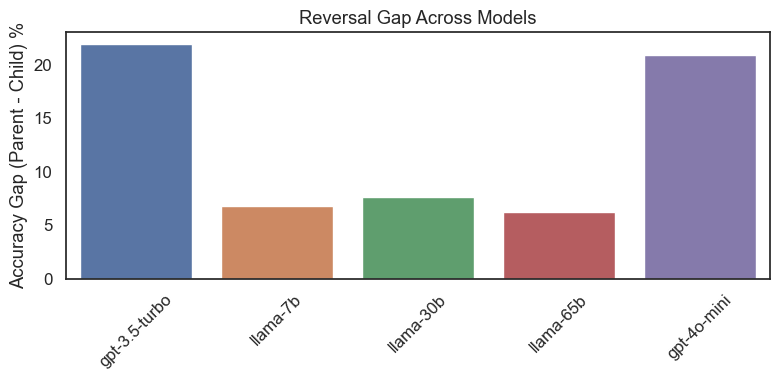

In [25]:
def plot_reversal_gaps(df: pd.DataFrame, model_names: list[str]):
    gaps = []
    for model in model_names:
        parent = df[f"{model}_parent_prob"].mean() * 100
        child = df[f"{model}_child_prob"].mean() * 100
        gaps.append(parent - child)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=model_names, y=gaps)
    plt.ylabel("Accuracy Gap (Parent - Child) %")
    plt.title("Reversal Gap Across Models")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_reversal_gaps(combined_df, ["gpt-3.5-turbo", "llama-7b", "llama-30b", "llama-65b", "gpt-4o-mini"])

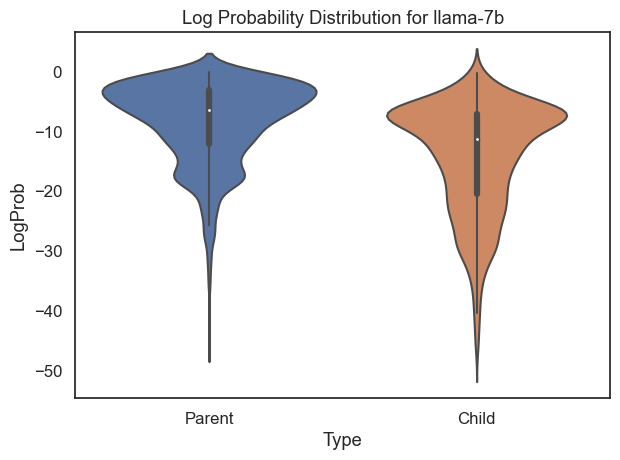

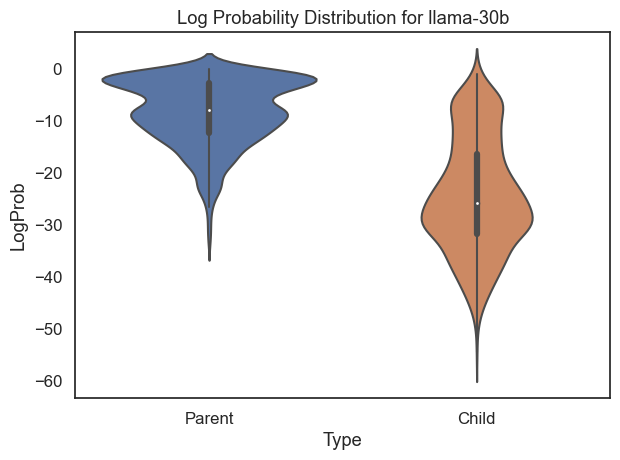

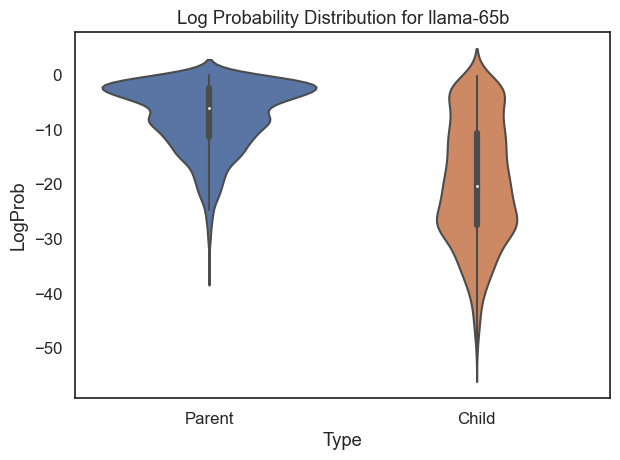

In [30]:
def plot_logprob_distributions(df: pd.DataFrame, model: str):
    data = pd.DataFrame({
        "Parent": df[f"{model}_parent_logprob"],
        "Child": df[f"{model}_child_logprob"]
    }).melt(var_name="Type", value_name="LogProb")

    sns.violinplot(x="Type", y="LogProb", data=data)
    plt.title(f"Log Probability Distribution for {model}")
    plt.tight_layout()
    plt.show()
    
plot_logprob_distributions(combined_df, "llama-7b")
plot_logprob_distributions(combined_df, "llama-30b")
plot_logprob_distributions(combined_df, "llama-65b")

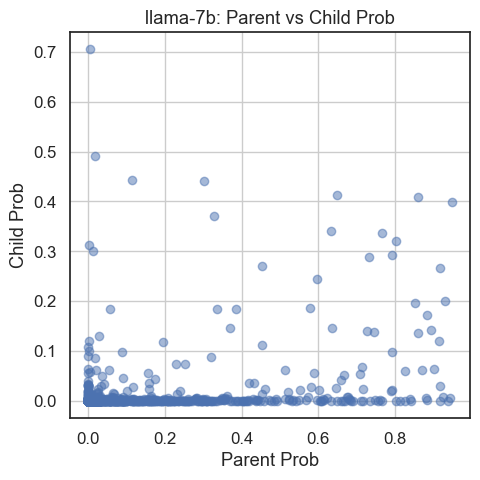

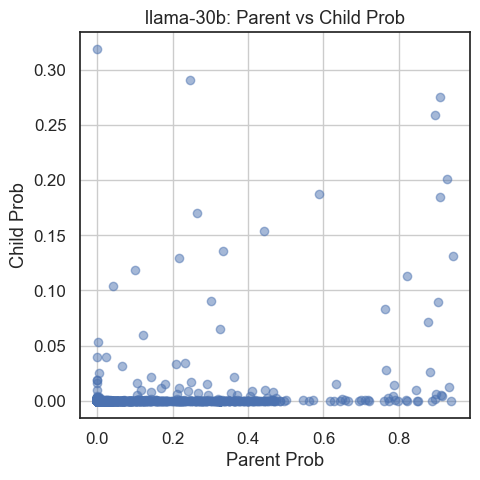

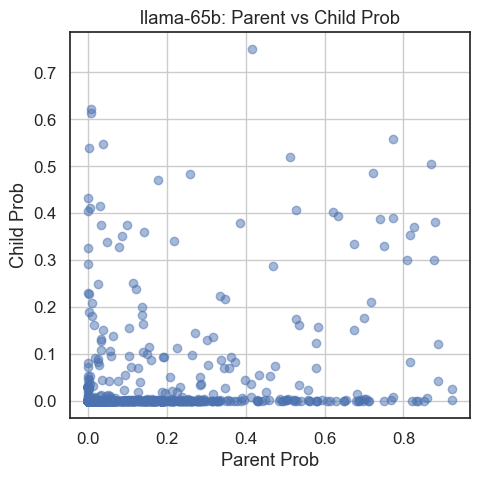

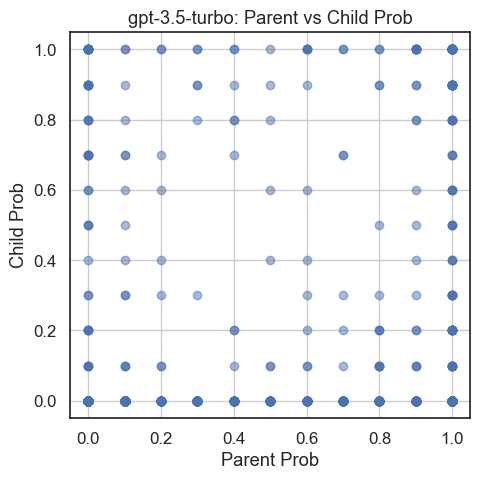

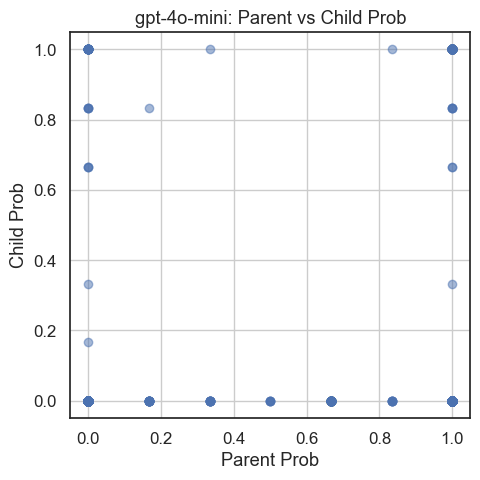

In [28]:
def scatter_probs(df: pd.DataFrame, model: str):
    plt.figure(figsize=(5, 5))
    plt.scatter(df[f"{model}_parent_prob"], df[f"{model}_child_prob"], alpha=0.5)
    plt.xlabel("Parent Prob")
    plt.ylabel("Child Prob")
    plt.title(f"{model}: Parent vs Child Prob")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
scatter_probs(combined_df, "llama-7b")
scatter_probs(combined_df, "llama-30b")
scatter_probs(combined_df, "llama-65b")
scatter_probs(combined_df, "gpt-3.5-turbo")
scatter_probs(combined_df, "gpt-4o-mini")

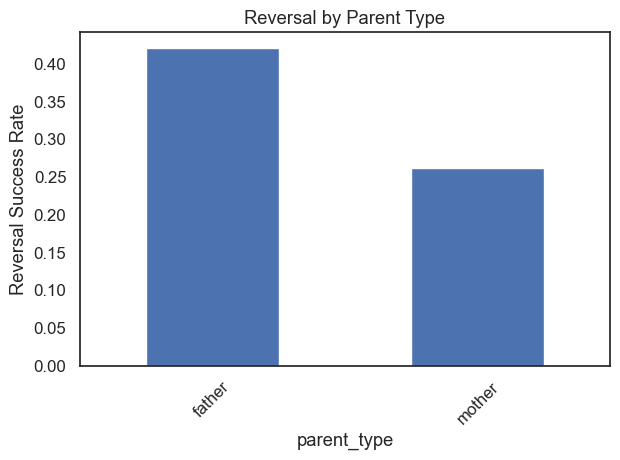

In [29]:
def barplot_reversibility_by_type(df: pd.DataFrame):
    type_acc = df.groupby("parent_type")["can_reverse"].mean().sort_values(ascending=False)
    type_acc.plot(kind="bar", ylabel="Reversal Success Rate", title="Reversal by Parent Type", rot=45)
    plt.tight_layout()
    plt.show()

barplot_reversibility_by_type(combined_df)

In [33]:
!pip install tabulate
import pandas as pd

def generate_summary_table(df, model_names):
    rows = []
    for model in model_names:
        parent_prob_col = f"{model}_parent_prob"
        child_prob_col = f"{model}_child_prob"
        parent_logprob_col = f"{model}_parent_logprob"
        child_logprob_col = f"{model}_child_logprob"

        parent_acc = df[parent_prob_col].mean() * 100 if parent_prob_col in df else None
        child_acc = df[child_prob_col].mean() * 100 if child_prob_col in df else None
        acc_gap = parent_acc - child_acc if parent_acc is not None and child_acc is not None else None

        parent_logprob = df[parent_logprob_col].mean() if parent_logprob_col in df else None
        child_logprob = df[child_logprob_col].mean() if child_logprob_col in df else None
        logprob_gap = parent_logprob - child_logprob if parent_logprob is not None and child_logprob is not None else None

        rows.append({
            "Model": model,
            "Parent Accuracy (%)": round(parent_acc, 1) if parent_acc is not None else "—",
            "Child Accuracy (%)": round(child_acc, 1) if child_acc is not None else "—",
            "Accuracy Gap": round(acc_gap, 1) if acc_gap is not None else "—",
            "Parent LogProb": round(parent_logprob, 2) if parent_logprob is not None else "—",
            "Child LogProb": round(child_logprob, 2) if child_logprob is not None else "—",
            "LogProb Gap": round(logprob_gap, 2) if logprob_gap is not None else "—",
        })

    return pd.DataFrame(rows)

# Example usage
if __name__ == "__main__":
    model_names = [
        "gpt-3.5-turbo", "llama-7b", "llama-30b",
        "llama-65b", "gpt-4o-mini", "davinci"
    ]
    summary_table = generate_summary_table(combined_df, model_names)
    print(summary_table.to_markdown(index=False))  # Or use .to_latex() / .to_csv()


| Model         |   Parent Accuracy (%) |   Child Accuracy (%) |   Accuracy Gap | Parent LogProb   | Child LogProb   | LogProb Gap   |
|:--------------|----------------------:|---------------------:|---------------:|:-----------------|:----------------|:--------------|
| gpt-3.5-turbo |                  33   |                 11   |           21.9 | —                | —               | —             |
| llama-7b      |                   7.6 |                  0.8 |            6.8 | -8.36            | -14.29          | 5.93          |
| llama-30b     |                   7.9 |                  0.3 |            7.6 | -8.4             | -24.46          | 16.05         |
| llama-65b     |                   7.9 |                  1.7 |            6.2 | -7.69            | -19.69          | 12.0          |
| gpt-4o-mini   |                  29.1 |                  8.2 |           20.9 | —                | —               | —             |
| davinci       |                   9.1 |              